# Training and Retrieval from centroid + BM25
This notebook uses the script for centroid retrieval parting from BM25 to retrieve a series of candidates usable for next models or even, snippet retrieval directly.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging
from pprint import pprint

import pandas as pd

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

from src.cemb_bm25 import centroid_retrieval
from src.elastic_search_utils.elastic_utils import load_json, save_json

## Params

In [2]:
BM25_QUESTIONS = '/datasets/johan_tests_original_format/training_docs_10b.json'

ABSTRACT_WEIGHT = 0.7
TITLE_WEIGHT = 0.3

## Saving directions

In [3]:
SAVING_FOLDER = '/datasets/johan_tests_original_format_centroid/original_training_docs/'

SAVING_ABSTRACT_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_abstract_model_10b_train.bin'
SAVING_TITLE_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_title_model_10b_train.bin'
SAVING_QUESTION_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_question_model_10b_train.bin'

SAVING_ORIGINAL_PATH = f'{SAVING_FOLDER}/training_original_10b.json'
SAVING_TOKENS_PATH = f'{SAVING_FOLDER}/training_tokens_10b.json'
SAVING_CLEANED_PATH = f'{SAVING_FOLDER}/training_cleaned_10b.json'

## Constants

In [4]:
questions = load_json(BM25_QUESTIONS)

## Extracting tokens for valid documents
Only documents with abstract will be kept.

One dict cleaned-tokenized, another only cleaned.

In [5]:
tokenized_unique_docs, cleaned_unique_docs = centroid_retrieval.extract_unique_doc_info(
    questions=questions['questions']
)

Extracting unique doc info: 100%|██████████| 4234/4234 [00:21<00:00, 201.44it/s]


## Tokenize question body and replace documents with tokenized documents

In [6]:
tokenized_questions, question_solving_doc_ids = centroid_retrieval.select_questions_useful_documents(
    questions=questions['questions'],
    unique_docs=tokenized_unique_docs,
    use_tokens=True
)

Selecting useful documents: 100%|█████████| 4234/4234 [00:01<00:00, 2341.19it/s]


In [7]:
tokenized_questions = {'questions': tokenized_questions}

## Clean question body and replace documents with cleaned documents

In [8]:
cleaned_questions, _ = centroid_retrieval.select_questions_useful_documents(
    questions=questions['questions'],
    unique_docs=cleaned_unique_docs,
    use_tokens=False
)

Selecting useful documents: 100%|█████████| 4234/4234 [00:01<00:00, 2905.98it/s]


In [9]:
cleaned_questions = {'questions': cleaned_questions}

## Extracting unique tokenized abstracts and titles for word2vec

In [10]:
unique_abstract_tokens, unique_title_tokens = centroid_retrieval.extract_unique_titles_and_abstracts(
    tokenized_unique_docs=tokenized_unique_docs,
    question_solving_doc_ids=question_solving_doc_ids
)

In [11]:
len(unique_abstract_tokens), len(unique_title_tokens)

(36743, 36743)

In [12]:
len(list(unique_abstract_tokens.values())[0]), len(list(unique_title_tokens.values())[0])

(152, 11)

## Extracting unique tokenized questions for word2vec

In [13]:
unique_question_tokens = centroid_retrieval.extract_unique_questions(
    tokenized_questions['questions']
)

In [14]:
len(unique_question_tokens)

4234

In [15]:
len(list(unique_question_tokens.values())[0])

9

## Making fit models w2vec models for questions, titles and abstracts

In [16]:
question_w2vec_model, question_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_question_tokens.values())

Word2Vec vocabulary length: 6671


In [17]:
abstract_w2vec_model, abstract_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_abstract_tokens.values())

Word2Vec vocabulary length: 128281


In [18]:
title_w2vec_model, title_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_title_tokens.values())

Word2Vec vocabulary length: 34808


## Saving models into disk

In [19]:
question_w2vec_model.save(SAVING_QUESTION_W2V_PATH)

In [20]:
abstract_w2vec_model.save(SAVING_ABSTRACT_W2V_PATH)

In [21]:
title_w2vec_model.save(SAVING_TITLE_W2V_PATH)

## Calculating centroids

In [22]:
question_centroids = centroid_retrieval.calculate_centroids(
    text_tokens=unique_question_tokens,
    model=question_w2vec_model,
    vocab=question_w2vec_vocab
)

Extracting centroids: 100%|██████████████| 4234/4234 [00:00<00:00, 38036.36it/s]


In [23]:
abstract_centroids = centroid_retrieval.calculate_centroids(
    text_tokens=unique_abstract_tokens,
    model=abstract_w2vec_model,
    vocab=abstract_w2vec_vocab
)

Extracting centroids: 100%|█████████████| 36743/36743 [00:07<00:00, 4629.33it/s]


In [24]:
title_centroids = centroid_retrieval.calculate_centroids(
    text_tokens=unique_title_tokens,
    model=title_w2vec_model,
    vocab=title_w2vec_vocab
)

Extracting centroids:  87%|██████████▍ | 32106/36743 [00:00<00:00, 40286.58it/s]/datasets/anaconda3/envs/tf2.8/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datasets/anaconda3/envs/tf2.8/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Extracting centroids: 100%|████████████| 36743/36743 [00:00<00:00, 39787.09it/s]


## Calculating question cosine similarities to answers

In [25]:
question_similarities = centroid_retrieval.calculate_question_answer_similarity(
    tokenized_questions=tokenized_questions['questions'],
    question_centroids=question_centroids,
    abstract_centroids=abstract_centroids,
    title_centroids=title_centroids
)

Calculating cosine similarity: 100%|██████| 4234/4234 [00:00<00:00, 7108.04it/s]


## Calculating document scores for questions

In [26]:
question_scores = centroid_retrieval.calculate_centroid_score(
    questions_similarities=question_similarities['questions'],
    abstract_weight=ABSTRACT_WEIGHT,
    title_weight=TITLE_WEIGHT
)

Calculating centroid distance: 100%|█████| 4234/4234 [00:00<00:00, 34529.14it/s]


## Selecting useful documents only from original question dictionaries
### Original dict (for Andres model)

In [27]:
centroid_retrieval.update_question_scores_from_raw_data(
    raw_questions=questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█| 4234/4234 [00:00<00:00, 212137


In [28]:
centroid_retrieval.update_question_scores(
    raw_questions=tokenized_questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█| 4234/4234 [00:00<00:00, 236158


In [29]:
centroid_retrieval.update_question_scores(
    raw_questions=cleaned_questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█| 4234/4234 [00:00<00:00, 221548


## Saving into disk

In [30]:
save_json(questions, SAVING_ORIGINAL_PATH)

In [31]:
save_json(tokenized_questions, SAVING_TOKENS_PATH)

In [32]:
save_json(cleaned_questions, SAVING_CLEANED_PATH)

## Plotting distribution of number of documents

In [33]:
len_docs = [len(question['documents']) for question in questions['questions']]

<AxesSubplot:>

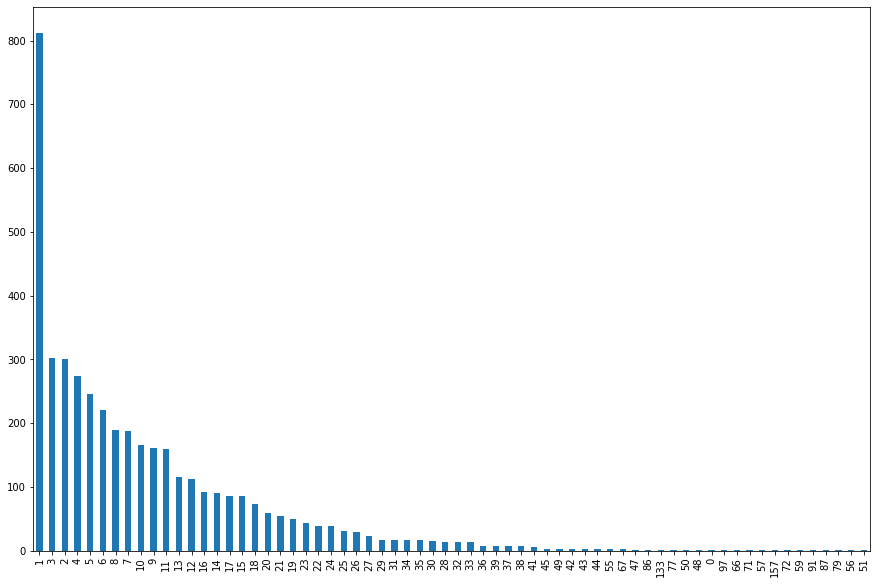

In [34]:
pd.value_counts(len_docs).sort_index().plot(kind='bar', figsize=(15,10))